<img src="Dau.png">

#### MASEF, University Paris-Dauphine 2021:   Bryan Delamour 

## Deep calibration of rough Bergomi parameters

#####  Reference : On deep calibration of (rough) stochastic volatility models

C. Bayer
B. Horvath
A. Muguruza
B. Stemper
M. Tomas


In [1]:
import numpy as np
from cmath import * 
import torch
import pickle
import os
from time import time 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from termcolor import colored
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt

## Strikes x Maturities grid

In [2]:
strikes = np.arange(0.5,1.6,0.1)
maturities = np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2])
S0=1


## Approximating the inverse map

We calibrate rough Bergomi parameters, i.e., we consider the simple map

$$
\Pi^{-1}\left(\Sigma_{\mathrm{BS}}^{\mathrm{r} \mathrm{Bergomi}}\right) \rightarrow\left(\hat{\xi}, \hat{\nu}, \hat{\rho}, \hat{H}\right)
$$

where $\Sigma_{\mathrm{BS}}^{\mathrm{rBergomi}} \in \mathbb{R}^{n \times m}$ is a rBergomi implied volatility surface and $\left(\hat{\xi}, \hat{\nu}, \hat{\rho}, \hat{H}\right)$ the optimal solution to the corresponding calibration problem.

### Objective function

$$\hat{w}=\underset{w}{\operatorname{argmin}} \sum_{i=1}^{N_{T r a i n}}\left(\xi_i - \hat{\xi}_{i}\right)^{2} + \left( \nu_i - \hat{\nu}_i \right) + \left( \rho_i - \hat{\rho}_i\right)^{2} + \left( H_i - \hat{H}_i\right)^{2}$$

$\hat{w}$ is the optimal network's weights.

## Neural network architecture

- 1 convolutional layer with 16 filters and $3 \times 3$ sliding window
- MaxPooling layer with $2 \times 2$ sliding window
- 50 Neuron Feedforward Layer with Elu activation function
- Output layer with linear activation function
- Total number of parameters: $10 014$


<img src="CNN_pic.png">

### Layer's initialization

Glorot initialization (xavier normal), layers' weights will have values sampled from : 


$$
\mathcal{N}\left(0,\sqrt{\frac{2}{\text { fan_in }+\text { fan_out }}} \right)
$$

Where,

$\text{fan_in = layer's input dimension}$


$\text{fan_out = layer's output dimension}$

##### Reference: Understanding the difficulty of training deep feedforward neural networks 
X. Glorot, Y. Bengio (2010)

In [3]:
# Convolutional Neural Network with:

hidden_dim = 30
input_dim = 11*8 # 11x8 IV surface 
output_dim = 4 # xi, nu, rho, H 

class NN_CAL(nn.Module):
    def __init__(self):
        
        super(NN_CAL, self).__init__()
        
        self.conv2D_1 = nn.Conv2d(1, 16, 3)
        self.Maxpool_1 = nn.MaxPool2d(2, 2)
        self.L1 = nn.Linear(16 * 4 * 3, 50)
        self.L2 = nn.Linear(50, 4)
        self.elu = nn.ELU(alpha=1, inplace=False)
        

# WEIGHTS INITIALIZATION         
        for name, param in self.conv2D_1.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
        for name, param in self.Maxpool_1.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)  
        for name, param in self.L1.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param) 
        for name, param in self.L2.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param) 
        
# Feedforward       
    def forward(self, iv_surface): # [ Batch_size , 1, 11, 8] 
                              
        conv = self.conv2D_1(iv_surface) #[ Batch_size , 16, 9, 6]

        activation1 = self.elu(conv) 

        maxpool = self.Maxpool_1(activation1)   #[Batch_size, 16, 4, 3]
                
        maxpool = maxpool.view(-1, 16 * 4 * 3) # [Batch_size, 16 * 4 * 3]
        
        lin1 = self.L1(maxpool)    # [Batch_size, 50]

        activation2 = self.elu(lin1)

        output = self.L2(activation2) # [Batch_size,  4 ]

        return output
    

In [4]:
# Function to count network's parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [5]:
# Model summary

NN_cal = NN_CAL()
print(NN_cal)
print("Number of parameters", count_parameters(NN_CAL()))


NN_CAL(
  (conv2D_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (Maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (L1): Linear(in_features=192, out_features=50, bias=True)
  (L2): Linear(in_features=50, out_features=4, bias=True)
  (elu): ELU(alpha=1)
)
Number of parameters 10014


## Loading iv surfaces and rBergomi parameters

In [6]:
# Data importation

iv_training_File = "iv_training_data.pkl" 
model_parameters_training_File = "model_parameters_training_data.pkl" 

with open(iv_training_File, 'rb') as file:  
    implied_vols = pickle.load(file)
    
with open(model_parameters_training_File, 'rb') as file:  
    model_parameters = pickle.load(file)
    
XI = model_parameters[:,0]
NU = model_parameters[:,1]
RHO = model_parameters[:,2]
H = model_parameters[:,3]


## Normalization of implied volatilities

$\bar{iv}_{\text {train }}$ the mean of the training set and the corresponding sample standard deviation $s_{\text {train }} $. For each input $iv^{(i)}$, its standardized version $\hat{iv}^{(i)}$ is given by

$$
\hat{iv}^{(i)}:=\frac{iv^{(i)}-\bar{iv}_{\text {train }}}{s_{\text {train }}}, \quad 1 \leq i \leq n
$$

where the operations are defined componentwise.

##### Reference: Deep Learning Volatility

B. Horvath, A. Muguruza, M. Tomas

In [7]:
# Normalization

mean_data = np.mean(implied_vols, axis = 0)
std_data = np.std(implied_vols, axis = 0)

implied_vols_N = (implied_vols - mean_data)/std_data


## Split training and test samples

In [8]:
# Split training and test

implied_vols_training =  torch.Tensor(implied_vols_N[:33792,:,:])
model_parameters_training =  torch.Tensor(model_parameters[:33792,:])

implied_vols_test =  torch.Tensor(implied_vols_N[34000:,:,:])
model_parameters_test =  torch.Tensor(model_parameters[34000:,:])


## Training procedure

### Adam minibatch training scheme


$w$ denotes the set of parameters - weights and biases $-$ of a neural network $F=F(w, x)$ Given parameters $0 \leq \beta_{1}, \beta_{2}<1, \epsilon, \alpha$, initial iterates $u_{0}:=0, v_{0}:=0, w_{0} \in \Omega$, the Adam scheme has the following iterates:


$$
\begin{aligned}
g_{n} &:=\nabla^{w} \sum_{i=1}^{m} \mathcal{L}\left(F\left(w_{n-1}, X_{n, m}^{\text {batch }}\right), F^{*}\left(X_{n, m}^{\text {batch }}\right)\right) \\
u_{n+1} &:=\beta_{1} u_{n}+\left(1-\beta_{1}\right) g_{n} \\
v_{n+1} &:=\beta_{2} v_{n}+\left(1-\beta_{2}\right) g_{n}^{2} \\
w_{n+1} &:=w_{n}-\alpha \frac{u_{n+1}}{1-\beta_{1}^{n+1}} \frac{1}{\sqrt{v_{n} /\left(1-\beta_{2}^{n+1}\right)}+\epsilon}
\end{aligned}
$$

#####  Reference : On deep calibration of (rough) stochastic volatility models

C. Bayer
B. Horvath
A. Muguruza
B. Stemper
M. Tomas


### Preventing overfitting

To prevent overfitting, between each epoch we sample new minibatches draw uniformly from the training set. This allows a better generalization of the network's solution. We will see its effect on the test set loss and the training set loss as both will follow the same decrease until the last epoch. The 'shuffle_batch' function below will therefore be used at the begining of each epoch.

In [9]:
def shuffle_batch(in_sample, out_sample, batch_size):
    rnd_idx = np.random.permutation(in_sample.shape[0])
    in_sample_batch = []
    out_sample_batch = []
    n_batches = in_sample.shape[0] // batch_size
    
    for batch_idx in np.array_split(rnd_idx, n_batches):
        in_sample_batch.append(in_sample[batch_idx,:])
        out_sample_batch.append(out_sample[batch_idx,:,:])
        
    return ( (in_sample_batch, out_sample_batch) )


### Rate decay

During the training, the solution provided by the network might come close to a local or global minimum, in this situation jumps in the loss can be seen and the loss won't be able to improve further. To prevent this situation we use a linear learning rate decay during starting at 0.005 at epoch 0, and decreasing until 0.0005 at the last epoch.

The learning rate at epoch $k$:
$$
\epsilon_{k}=(1-\alpha) \epsilon_{0}+\alpha \epsilon_{\tau}
$$

with $\alpha=\frac{k}{\tau}$ ,
$\tau=200$.

##### Reference: Deep Learning
I. Goodfellow, Y. Bengio, A. Courville, Chapter 8

### Early stopping variant

We keep training the network until the last epoch, however we won't save the model unless the loss improved.

In fact, we will see that in our case the loss keeps improving until the last epoch.

### Training parameters

$\text{Batch size} = 128$

$\text{Number of epochs} = 400$

$ \text{Starting learning rate} = 5\times 10^{-3} $

$ \text{Ending learning rate} = 5\times 10^{-5} $

In [10]:
# Training setting 

learning_rate = 0.005 
batch_size = 128 
epochs = 400
nb_batch = model_parameters_training.shape[0]//batch_size #nb of patch / set
optimizer = torch.optim.Adam(NN_cal.parameters(), lr=learning_rate)
loss = nn.MSELoss()


In [11]:
# At each epoch, saving test/training loss, and learning rates 

min_loss = 10
LOSS_B = []
LOSS_test = []
training_rates = [learning_rate]

# Saving the network

NN_cal_model_File = "NN_cal_model.pkl" 


In [12]:
# Rate decay

tau = epochs
min_rate = 0.01*learning_rate


In [13]:
# Functions used to reshape network's output to a matrix

def vector(matrix):
    x = matrix[:,0,:]
    for i in range(1,matrix.shape[1]):
        x = torch.cat((x,matrix[:,i,:]), dim=1)
    return(x)

def matrix(vector,rows,colums):
    x = torch.zeros((vector.shape[0],rows,colums))
    for i in range(vector.shape[0]):
        for j in range(rows):
            x[i,j,:] = vector[i,j*colums:(j+1)*colums]
    return(x)


In [14]:
# Training

t1 = time()

for epoch in range(epochs):
    
    loss_b = 0
    
    in_sample_batch, out_sample_batch = shuffle_batch(model_parameters_training, implied_vols_training, batch_size)
    
    for in_sample, out_sample in zip(in_sample_batch, out_sample_batch) :

        optimizer.zero_grad()
        
        out_sample = torch.reshape( out_sample , (batch_size, 1, 11, 8 ) )

        output = NN_cal(out_sample)
        
        loss_batch = loss(output,in_sample)

        loss_b += loss_batch/nb_batch    
        
        loss_batch.backward()
        optimizer.step()
    
        min_loss = min(min_loss,loss_batch)
      
    LOSS_B.append(loss_b.item())
         
    output = NN_cal( torch.reshape( implied_vols_test , (implied_vols_test.shape[0], 1, 11, 8 ) ) )
    
    test = loss(output,model_parameters_test)
    LOSS_test.append(test)
    
    if (test<=min(LOSS_test)):
        with open(NN_cal_model_File, 'wb') as file:  
            pickle.dump(NN_cal, file)      
    
    print(colored("Epoch:",'red'), epoch,colored("Training Loss:",'red'), colored(loss_b.item(),'red') )
    print(colored("Test Loss ", 'green'), colored(test.item(),'green'))
    print("Current Learning Rate", training_rates[-1] )
    print( "Best Training Loss", min(LOSS_B))
    print('Best Batch Loss',min_loss.item()) 
    print("Min Test Loss", min(LOSS_test).item(), '\n')
   
    if (epoch<tau):
        rate = (1-(epoch/tau))*learning_rate + (epoch/tau)*min_rate 
        optimizer.param_groups[0]['lr'] = rate
        training_rates.append(rate)
      
    else:
        rate = min_rate 
        optimizer.param_groups[0]['lr'] = rate
        training_rates.append(rate)
    
t2 = time()


Epoch: 0 Training Loss: 0.04135572165250778
Test Loss  0.007454408798366785
Current Learning Rate 0.005
Best Training Loss 0.04135572165250778
Best Batch Loss 0.005035483743995428
Min Test Loss 0.007454408798366785 

Epoch: 1 Training Loss: 0.00600444944575429
Test Loss  0.004569554701447487
Current Learning Rate 0.005
Best Training Loss 0.00600444944575429
Best Batch Loss 0.003477180376648903
Min Test Loss 0.004569554701447487 

Epoch: 2 Training Loss: 0.003554594935849309
Test Loss  0.002521171234548092
Current Learning Rate 0.004987625000000001
Best Training Loss 0.003554594935849309
Best Batch Loss 0.0020538009703159332
Min Test Loss 0.002521171234548092 

Epoch: 3 Training Loss: 0.0022257990203797817
Test Loss  0.0024189080577343702
Current Learning Rate 0.0049752500000000005
Best Training Loss 0.0022257990203797817
Best Batch Loss 0.0013490745332092047
Min Test Loss 0.0024189080577343702 

Epoch: 4 Training Loss: 0.0017000571824610233
Test Loss  0.0021225500386208296
Current Lear

Epoch: 30 Training Loss: 0.000433989567682147
Test Loss  0.0004138005315326154
Current Learning Rate 0.004641125
Best Training Loss 0.0003899073344655335
Best Batch Loss 0.00018432103388477117
Min Test Loss 0.00030574348056688905 

Epoch: 31 Training Loss: 0.0003833983209915459
Test Loss  0.0005139975692145526
Current Learning Rate 0.004628750000000001
Best Training Loss 0.0003833983209915459
Best Batch Loss 0.00016638835950288922
Min Test Loss 0.00030574348056688905 

Epoch: 32 Training Loss: 0.0004227440804243088
Test Loss  0.0005762676009908319
Current Learning Rate 0.004616375000000001
Best Training Loss 0.0003833983209915459
Best Batch Loss 0.00016638835950288922
Min Test Loss 0.00030574348056688905 

Epoch: 33 Training Loss: 0.0004675083328038454
Test Loss  0.00033466864260844886
Current Learning Rate 0.004604
Best Training Loss 0.0003833983209915459
Best Batch Loss 0.00015463701856788248
Min Test Loss 0.00030574348056688905 

Epoch: 34 Training Loss: 0.0003659138747025281
Test L

Epoch: 60 Training Loss: 0.00021294114412739873
Test Loss  0.000245393137447536
Current Learning Rate 0.004269875
Best Training Loss 0.0002082947758026421
Best Batch Loss 9.017697448143736e-05
Min Test Loss 0.00017293608107138425 

Epoch: 61 Training Loss: 0.00024219632905442268
Test Loss  0.0002614004770293832
Current Learning Rate 0.0042575
Best Training Loss 0.0002082947758026421
Best Batch Loss 9.017697448143736e-05
Min Test Loss 0.00017293608107138425 

Epoch: 62 Training Loss: 0.0002591671363916248
Test Loss  0.00013760697038378567
Current Learning Rate 0.004245125
Best Training Loss 0.0002082947758026421
Best Batch Loss 9.017697448143736e-05
Min Test Loss 0.00013760697038378567 

Epoch: 63 Training Loss: 0.0001982570975087583
Test Loss  0.00016547449922654778
Current Learning Rate 0.0042327499999999995
Best Training Loss 0.0001982570975087583
Best Batch Loss 9.017697448143736e-05
Min Test Loss 0.00013760697038378567 

Epoch: 64 Training Loss: 0.00025868561351671815
Test Loss  0.

Epoch: 90 Training Loss: 0.00017844758986029774
Test Loss  0.00013348330685403198
Current Learning Rate 0.0038986249999999997
Best Training Loss 0.00017651432426646352
Best Batch Loss 7.41094772820361e-05
Min Test Loss 0.00012198100739624351 

Epoch: 91 Training Loss: 0.00018192327115684748
Test Loss  0.00015798948879819363
Current Learning Rate 0.0038862500000000004
Best Training Loss 0.00017651432426646352
Best Batch Loss 7.41094772820361e-05
Min Test Loss 0.00012198100739624351 

Epoch: 92 Training Loss: 0.00021769848535768688
Test Loss  0.00010963942622765899
Current Learning Rate 0.003873875
Best Training Loss 0.00017651432426646352
Best Batch Loss 7.374430424533784e-05
Min Test Loss 0.00010963942622765899 

Epoch: 93 Training Loss: 0.0001669873745413497
Test Loss  0.00021939339058008045
Current Learning Rate 0.0038615
Best Training Loss 0.0001669873745413497
Best Batch Loss 7.23130360711366e-05
Min Test Loss 0.00010963942622765899 

Epoch: 94 Training Loss: 0.00017002900131046772

Epoch: 119 Training Loss: 0.0001487138360971585
Test Loss  0.0001446460810257122
Current Learning Rate 0.0035397500000000004
Best Training Loss 0.000134487243485637
Best Batch Loss 6.657873746007681e-05
Min Test Loss 0.00010824672062881291 

Epoch: 120 Training Loss: 0.00015046699263621122
Test Loss  9.442267764825374e-05
Current Learning Rate 0.003527375
Best Training Loss 0.000134487243485637
Best Batch Loss 6.657873746007681e-05
Min Test Loss 9.442267764825374e-05 

Epoch: 121 Training Loss: 0.0001231700589414686
Test Loss  0.0001449449046049267
Current Learning Rate 0.0035149999999999995
Best Training Loss 0.0001231700589414686
Best Batch Loss 6.57590790069662e-05
Min Test Loss 9.442267764825374e-05 

Epoch: 122 Training Loss: 0.00013945807586424053
Test Loss  0.0002452525368425995
Current Learning Rate 0.003502625
Best Training Loss 0.0001231700589414686
Best Batch Loss 6.57590790069662e-05
Min Test Loss 9.442267764825374e-05 

Epoch: 123 Training Loss: 0.00016470326227135956
Test

Epoch: 148 Training Loss: 0.00012079054431524128
Test Loss  0.0001043633819790557
Current Learning Rate 0.0031808750000000005
Best Training Loss 0.0001120196538977325
Best Batch Loss 5.177079947316088e-05
Min Test Loss 8.847450953908265e-05 

Epoch: 149 Training Loss: 0.0001265722676180303
Test Loss  0.00015758218069095165
Current Learning Rate 0.0031685
Best Training Loss 0.0001120196538977325
Best Batch Loss 5.177079947316088e-05
Min Test Loss 8.847450953908265e-05 

Epoch: 150 Training Loss: 0.00011053212074330077
Test Loss  0.00014753110008314252
Current Learning Rate 0.0031561249999999996
Best Training Loss 0.00011053212074330077
Best Batch Loss 5.177079947316088e-05
Min Test Loss 8.847450953908265e-05 

Epoch: 151 Training Loss: 0.00011486824223538861
Test Loss  0.00017863760876934975
Current Learning Rate 0.0031437500000000003
Best Training Loss 0.00011053212074330077
Best Batch Loss 5.177079947316088e-05
Min Test Loss 8.847450953908265e-05 

Epoch: 152 Training Loss: 0.00012072

Epoch: 178 Training Loss: 0.00010052399011328816
Test Loss  8.573413651902229e-05
Current Learning Rate 0.002809625
Best Training Loss 9.731092723086476e-05
Best Batch Loss 4.8187896027229726e-05
Min Test Loss 8.07429023552686e-05 

Epoch: 179 Training Loss: 0.00011274166899966076
Test Loss  0.00017916352953761816
Current Learning Rate 0.00279725
Best Training Loss 9.731092723086476e-05
Best Batch Loss 4.8187896027229726e-05
Min Test Loss 8.07429023552686e-05 

Epoch: 180 Training Loss: 0.00010497821494936943
Test Loss  9.708571451483294e-05
Current Learning Rate 0.002784875
Best Training Loss 9.731092723086476e-05
Best Batch Loss 4.8187896027229726e-05
Min Test Loss 8.07429023552686e-05 

Epoch: 181 Training Loss: 9.799025428947061e-05
Test Loss  0.00010075469617731869
Current Learning Rate 0.0027725000000000002
Best Training Loss 9.731092723086476e-05
Best Batch Loss 4.8187896027229726e-05
Min Test Loss 8.07429023552686e-05 

Epoch: 182 Training Loss: 9.721505921334028e-05
Test Loss 

Epoch: 208 Training Loss: 9.82332494459115e-05
Test Loss  0.0001315791450906545
Current Learning Rate 0.002438375
Best Training Loss 8.799086936051026e-05
Best Batch Loss 3.906807251041755e-05
Min Test Loss 7.282342266989872e-05 

Epoch: 209 Training Loss: 9.061142918653786e-05
Test Loss  8.761763456277549e-05
Current Learning Rate 0.0024259999999999998
Best Training Loss 8.799086936051026e-05
Best Batch Loss 3.906807251041755e-05
Min Test Loss 7.282342266989872e-05 

Epoch: 210 Training Loss: 8.436197822447866e-05
Test Loss  7.552756142104045e-05
Current Learning Rate 0.0024136250000000004
Best Training Loss 8.436197822447866e-05
Best Batch Loss 3.906807251041755e-05
Min Test Loss 7.282342266989872e-05 

Epoch: 211 Training Loss: 9.081729513127357e-05
Test Loss  0.00011928159074159339
Current Learning Rate 0.0024012499999999997
Best Training Loss 8.436197822447866e-05
Best Batch Loss 3.906807251041755e-05
Min Test Loss 7.282342266989872e-05 

Epoch: 212 Training Loss: 8.78456703503616

Epoch: 238 Training Loss: 8.130849892040715e-05
Test Loss  8.175389666575938e-05
Current Learning Rate 0.002067125
Best Training Loss 7.70337283029221e-05
Best Batch Loss 3.8038589991629124e-05
Min Test Loss 7.003876817179844e-05 

Epoch: 239 Training Loss: 8.320291090058163e-05
Test Loss  6.998659227974713e-05
Current Learning Rate 0.00205475
Best Training Loss 7.70337283029221e-05
Best Batch Loss 3.8038589991629124e-05
Min Test Loss 6.998659227974713e-05 

Epoch: 240 Training Loss: 7.972079765750095e-05
Test Loss  8.385636465391144e-05
Current Learning Rate 0.002042375
Best Training Loss 7.70337283029221e-05
Best Batch Loss 3.8038589991629124e-05
Min Test Loss 6.998659227974713e-05 

Epoch: 241 Training Loss: 7.669290789635852e-05
Test Loss  7.156108040362597e-05
Current Learning Rate 0.00203
Best Training Loss 7.669290789635852e-05
Best Batch Loss 3.8038589991629124e-05
Min Test Loss 6.998659227974713e-05 

Epoch: 242 Training Loss: 7.815514982212335e-05
Test Loss  7.536664634244516

Epoch: 268 Training Loss: 6.790790939703584e-05
Test Loss  5.8746813010657206e-05
Current Learning Rate 0.0016958750000000001
Best Training Loss 6.638951163040474e-05
Best Batch Loss 3.614578236010857e-05
Min Test Loss 5.52634010091424e-05 

Epoch: 269 Training Loss: 6.990831752773374e-05
Test Loss  8.204425103031099e-05
Current Learning Rate 0.0016834999999999997
Best Training Loss 6.638951163040474e-05
Best Batch Loss 3.614578236010857e-05
Min Test Loss 5.52634010091424e-05 

Epoch: 270 Training Loss: 7.399156311294064e-05
Test Loss  8.66260306793265e-05
Current Learning Rate 0.001671125
Best Training Loss 6.638951163040474e-05
Best Batch Loss 3.614578236010857e-05
Min Test Loss 5.52634010091424e-05 

Epoch: 271 Training Loss: 7.049295527394861e-05
Test Loss  6.875292456243187e-05
Current Learning Rate 0.0016587499999999996
Best Training Loss 6.638951163040474e-05
Best Batch Loss 3.614578236010857e-05
Min Test Loss 5.52634010091424e-05 

Epoch: 272 Training Loss: 6.868541095172986e-0

Epoch: 297 Training Loss: 6.23602099949494e-05
Test Loss  6.0013000620529056e-05
Current Learning Rate 0.001337
Best Training Loss 5.816149860038422e-05
Best Batch Loss 3.1774827220942825e-05
Min Test Loss 5.047723607276566e-05 

Epoch: 298 Training Loss: 5.8790985349332914e-05
Test Loss  5.934404180152342e-05
Current Learning Rate 0.0013246249999999998
Best Training Loss 5.816149860038422e-05
Best Batch Loss 3.1774827220942825e-05
Min Test Loss 5.047723607276566e-05 

Epoch: 299 Training Loss: 6.303888221736997e-05
Test Loss  5.8617522881831974e-05
Current Learning Rate 0.00131225
Best Training Loss 5.816149860038422e-05
Best Batch Loss 3.1774827220942825e-05
Min Test Loss 5.047723607276566e-05 

Epoch: 300 Training Loss: 5.9230962506262586e-05
Test Loss  5.440440872916952e-05
Current Learning Rate 0.0012998749999999998
Best Training Loss 5.816149860038422e-05
Best Batch Loss 3.0694773158757016e-05
Min Test Loss 5.047723607276566e-05 

Epoch: 301 Training Loss: 5.587542909779586e-05
T

Epoch: 326 Training Loss: 5.3323972679208964e-05
Test Loss  5.3023330110590905e-05
Current Learning Rate 0.000978125
Best Training Loss 5.1204569899709895e-05
Best Batch Loss 2.8742066206177697e-05
Min Test Loss 4.8205009079538286e-05 

Epoch: 327 Training Loss: 5.129577039042488e-05
Test Loss  5.8415949752088636e-05
Current Learning Rate 0.0009657500000000002
Best Training Loss 5.1204569899709895e-05
Best Batch Loss 2.8742066206177697e-05
Min Test Loss 4.8205009079538286e-05 

Epoch: 328 Training Loss: 5.142170994076878e-05
Test Loss  5.222934123594314e-05
Current Learning Rate 0.000953375
Best Training Loss 5.1204569899709895e-05
Best Batch Loss 2.8742066206177697e-05
Min Test Loss 4.8205009079538286e-05 

Epoch: 329 Training Loss: 5.2512699767248705e-05
Test Loss  5.27987394889351e-05
Current Learning Rate 0.0009410000000000003
Best Training Loss 5.1204569899709895e-05
Best Batch Loss 2.8742066206177697e-05
Min Test Loss 4.8205009079538286e-05 

Epoch: 330 Training Loss: 5.361923103

Epoch: 355 Training Loss: 4.647449895855971e-05
Test Loss  5.123788650962524e-05
Current Learning Rate 0.00061925
Best Training Loss 4.5056669478071854e-05
Best Batch Loss 2.6197745683020912e-05
Min Test Loss 4.378689845907502e-05 

Epoch: 356 Training Loss: 4.491975414566696e-05
Test Loss  4.5526143367169425e-05
Current Learning Rate 0.0006068750000000003
Best Training Loss 4.491975414566696e-05
Best Batch Loss 2.6197745683020912e-05
Min Test Loss 4.378689845907502e-05 

Epoch: 357 Training Loss: 4.529406942310743e-05
Test Loss  4.847660238738172e-05
Current Learning Rate 0.0005945
Best Training Loss 4.491975414566696e-05
Best Batch Loss 2.570335527707357e-05
Min Test Loss 4.378689845907502e-05 

Epoch: 358 Training Loss: 4.3545267544686794e-05
Test Loss  4.286722469259985e-05
Current Learning Rate 0.0005821250000000002
Best Training Loss 4.3545267544686794e-05
Best Batch Loss 2.570335527707357e-05
Min Test Loss 4.286722469259985e-05 

Epoch: 359 Training Loss: 4.517004708759487e-05
T

Epoch: 384 Training Loss: 3.9146900235209614e-05
Test Loss  3.942936018574983e-05
Current Learning Rate 0.0002603749999999999
Best Training Loss 3.893287794198841e-05
Best Batch Loss 2.2504091248265468e-05
Min Test Loss 3.942936018574983e-05 

Epoch: 385 Training Loss: 3.893740358762443e-05
Test Loss  3.8896392652532086e-05
Current Learning Rate 0.0002480000000000002
Best Training Loss 3.893287794198841e-05
Best Batch Loss 2.2504091248265468e-05
Min Test Loss 3.8896392652532086e-05 

Epoch: 386 Training Loss: 3.903924152837135e-05
Test Loss  3.9627419027965516e-05
Current Learning Rate 0.00023562499999999989
Best Training Loss 3.893287794198841e-05
Best Batch Loss 2.2504091248265468e-05
Min Test Loss 3.8896392652532086e-05 

Epoch: 387 Training Loss: 3.843797094305046e-05
Test Loss  4.004547372460365e-05
Current Learning Rate 0.00022325000000000017
Best Training Loss 3.843797094305046e-05
Best Batch Loss 2.2504091248265468e-05
Min Test Loss 3.8896392652532086e-05 

Epoch: 388 Training 

## Loss evolution during training

The test sample loss (green) is computed at each epoch, however the network's weights are not updated according to this loss. 

It illustrates how well the network's solution generalizes to unseen data, and allows us to check for overfitting and learning rates adjustment.

Finale Validation Loss 3.574501897674054e-05
Best Validation Loss 3.574501897674054e-05
Finale Test Loss 3.822863436653279e-05
Best Test Loss 3.804016159847379e-05
Data Size torch.Size([33792, 4])
Training Time (h) 0.14192170249091254 

Evolution during training
Quadratic loss evolution during training


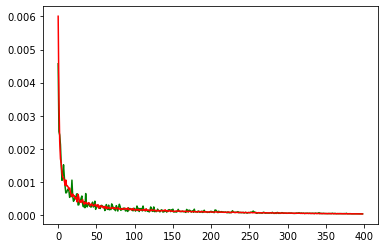

Learning Rates evolution during


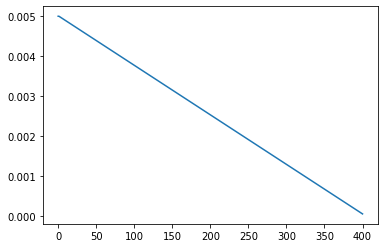

In [15]:
print( colored('Finale Validation Loss','red') , colored(loss_b.item(),'red'))
print( colored('Best Validation Loss', 'green'), min(LOSS_B))
print(colored('Finale Test Loss', 'red'), LOSS_test[-1].item()) 
print(colored('Best Test Loss', 'green' ), min(LOSS_test).item() )
print('Data Size', model_parameters_training.shape)
print("Training Time (h)", (t2-t1)/3600 ,'\n') 

print( "Evolution during training")


print( "Quadratic loss evolution during training")
plt.plot(LOSS_test[1:],color='green')
plt.plot(LOSS_B[1:],color='red')
plt.show()

print("Learning Rates evolution during")
plt.plot(training_rates)
plt.show()


## Accuracy of the inverse map as learned by the network

### Relative Error

Relative error here is computed as 
$$\frac{\left|\theta^{N N}-\theta \right|}{\left|\theta\right|}
$$

In [16]:
def average_RE(pred, true):
    return (torch.mean( abs(pred-true)/abs(true) , dim=0))

def RE(pred,true):
    return( abs(pred-true)/abs(true) )

In [17]:
output = NN_cal( torch.reshape( implied_vols_test , (implied_vols_test.shape[0], 1, 11, 8 ) ) )

Av_RE = average_RE(output, model_parameters_test)
RE_ = RE(output, model_parameters_test)

In [18]:
XI = model_parameters_test[:,0]
NU = model_parameters_test[:,1]
RHO = model_parameters_test[:,2]
H = model_parameters_test[:,3]


RE_xi = RE_[:,0]
RE_nu = RE_[:,1]
RE_rho = RE_[:,2]
RE_H = RE_[:,3]

print( 'Average relative error for all parameters ', torch.mean(Av_RE).item())

Average relative error for all parameters  0.011722007766366005


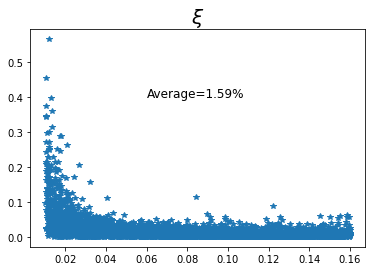

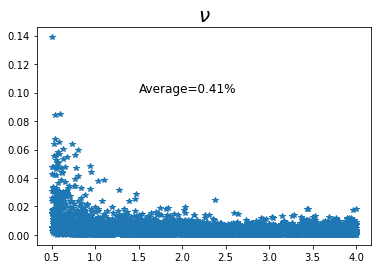

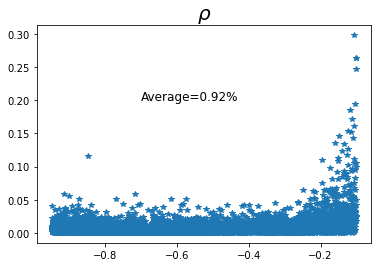

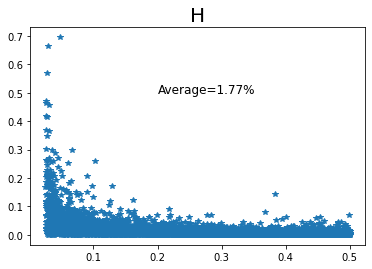

In [60]:
plt.title(r'$\xi$', fontsize = 20)
plt.text(0.06,0.4, 'Average='+str(np.round(Av_RE[0].item()*100,2))+'%', fontsize = 12)
plt.plot(XI,RE_xi.detach().numpy(), '*')
plt.show()


plt.title(r'$\nu$', fontsize = 20)
plt.text(1.5,0.1, 'Average='+str(np.round(Av_RE[1].item()*100,2))+'%', fontsize = 12)
plt.plot(NU,RE_nu.detach().numpy(), '*')
plt.show()

plt.title(r'$\rho$', fontsize = 20)
plt.text(-0.7,0.2, 'Average='+str(np.round(Av_RE[2].item()*100,2))+'%', fontsize = 12)
plt.plot(RHO,RE_rho.detach().numpy(), '*')
plt.show()


plt.title('H', fontsize = 20)
plt.text(0.2,0.5, 'Average='+str(np.round(Av_RE[3].item()*100,2))+'%', fontsize = 12)
plt.plot(H,RE_H.detach().numpy(), '*')
plt.show()

## Relative error distribution

quantile 90% =  0.02476830966770649
quantile 95% =  0.03967531770467758
quantile 99% =  0.11209042370319366


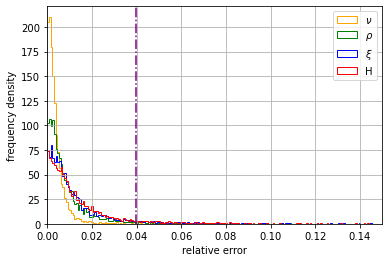

In [62]:
RE_ = torch.reshape(RE_, (6000*4,1))
sorted_re_ = sorted(RE_)

q_90 = sorted_re_[int(0.90*len(RE_.detach().numpy()))]
q_95 = sorted_re_[int(0.95*len(RE_.detach().numpy()))]
q_99 = sorted_re_[int(0.99*len(RE_.detach().numpy()))]

print('quantile 90% = ', q_90.item())
print('quantile 95% = ', q_95.item())
print('quantile 99% = ', q_99.item())

RE_xi = torch.reshape(RE_xi, (6000,1))
sorted_re_xi = sorted(RE_xi)

RE_nu = torch.reshape(RE_nu, (6000,1))
sorted_re_nu = sorted(RE_nu)

RE_rho = torch.reshape(RE_rho, (6000,1))
sorted_re_rho = sorted(RE_rho)

RE_H = torch.reshape(RE_H, (6000,1))
sorted_re_h = sorted(RE_H)

plt.hist(RE_nu.detach().numpy(), bins=np.linspace(0, 0.15, 200),histtype='step', density=True,label =r'$\nu$', rwidth=0.5, color='orange')
plt.hist(RE_rho.detach().numpy(), bins=np.linspace(0, 0.15, 200),histtype='step', density=True,label =r'$\rho$', rwidth=0.5, color='green')
plt.hist(RE_xi.detach().numpy(), bins=np.linspace(0, 0.15, 200),histtype='step', density=True,label =r'$\xi$', rwidth=0.5, color= 'blue')
plt.hist(RE_H.detach().numpy(), bins=np.linspace(0, 0.15, 200),histtype='step', density=True,label ='H', rwidth=0.5, color='red')
plt.xlim((0, 0.15))

plt.axvline(x=q_95, ls='-.', color='purple')

plt.grid(True)

plt.xlabel("relative error")
plt.ylabel("frequency density")
plt.legend()
plt.show()
